# `KNN Implementation Notebook`

### `Importing Libraries`

This section contains the Libraries we have used
1. pandas for dataframe processes
2. sklearn and Scipy for using built-in KNN, cosine similarity and Mean Absolute Error 
3. Matplotlib for graphing 

In [1]:
import pandas as pd 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import math  
import sklearn.metrics  
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-whitegrid')


In [2]:
# Loading the dataframe
df = pd.read_csv('ratings_small.csv')

### `Describe the Data`   

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df.shape

(100004, 4)

In [5]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [6]:
df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [7]:
df = df.drop(columns=['timestamp'])
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### `KNN Implementation`

#### `1. Pivot data`
  - create a table that is user to movies are are filled inside with ratings
  - Normalize data
    - find average
    - subtract average from all ratings 
    - fill null with zero 

In [8]:
#pivoting the data 
user_ratings_pivot1 = df.pivot(index = 'userId', columns = 'movieId', values = 'rating')
user_ratings_pivot1.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#filling missing values by centralizing 
avg_ratings = user_ratings_pivot1.mean(axis = 1)
user_ratings_pivot2 = user_ratings_pivot1.sub(avg_ratings , axis = 0)
user_ratings_pivot2 = user_ratings_pivot2.fillna(0)
user_ratings_pivot2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `2. Create the similarity matrix`
This matrix will be between user and user to find similar users 


`1. separate the user we are trying to find his rating`

In [10]:
target_user = user_ratings_pivot2.iloc[[1]]
target_user.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2. remove the movie we are trying to predict`

In [11]:
remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
remove_movie_we_are_predicting.head()

movieId,2,3,4,5,6,7,8,9,10,11,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`3. make a dataframe with users who watched this particular movie `

In [12]:
users_watched_this_movie = user_ratings_pivot1[1]
df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
users_watched_this_movie.dropna(inplace = True)

In [13]:
df_filled_users_watched_thismovie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
7,-0.465909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.465909,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.244444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1.254717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.621765,-0.621765,0.000000,0.000000,1.878235,1.378235,0.000000,0.0,0.000000,0.378235,...,0.0,-2.121765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,-0.534279,-0.534279,-0.534279,-0.534279,0.000000,-0.534279,-0.534279,0.0,-0.534279,-0.534279,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
users_watched_this_movie.head()

userId
7     3.0
9     4.0
13    5.0
15    2.0
19    3.0
Name: 1, dtype: float64

#### `3. Use the KNeighborsRegressor`

`Using cosine similarity`

In [15]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)
user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred = user_knn.predict(target_user)
print(user_user_pred)

[4.2]


`Using jaccard similarity`

In [16]:
user_knn2 = KNeighborsRegressor(metric='jaccard', n_neighbors=3)
user_knn2.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred2 = user_knn2.predict(target_user)
print(user_user_pred2)

[4.33333333]


`Using Euclidean Distance`

In [17]:
user_knn3 = KNeighborsRegressor(metric='euclidean', n_neighbors=3)
user_knn3.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred3 = user_knn3.predict(target_user)
print(user_user_pred3)

[3.66666667]


`Using Manhattan Distance`

In [18]:
user_knn4 = KNeighborsRegressor(metric='manhattan', n_neighbors=3)
user_knn4.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred4 = user_knn4.predict(target_user)
print(user_user_pred4)

[3.66666667]


### `Find datapoints that have values`

To be able to evaluate properly, we need to find the datapoints that are already filled with data. Those will be the positions of those in the matrix to be able to refer to them efficiently, without repeatedily trying to find the values with values.

In [19]:
#find 10 points were there is a movie and not nan
#def find_not_nan(movie):
j=0
l=[]
list_columns = user_ratings_pivot1.columns
for i in user_ratings_pivot1.iloc[1]:
    if not(np.isnan(i)) :
        l.append(list_columns[j])
    j=j+1
        
print(l)

[10, 17, 39, 47, 50, 52, 62, 110, 144, 150, 153, 161, 165, 168, 185, 186, 208, 222, 223, 225, 235, 248, 253, 261, 265, 266, 272, 273, 292, 296, 300, 314, 317, 319, 339, 349, 350, 356, 357, 364, 367, 370, 371, 372, 377, 382, 405, 410, 454, 457, 468, 474, 480, 485, 497, 500, 508, 509, 515, 527, 537, 539, 550, 551, 552, 585, 586, 587, 588, 589, 590, 592, 593, 616, 661, 720]


In [20]:
original = []
for i in l[0:50]:
    original.append(user_ratings_pivot1.iloc[1][i])
print(original)

[4.0, 5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 1.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 3.0, 4.0, 3.0, 4.0, 3.0, 4.0, 2.0, 1.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 3.0]


### `Testing 4 algorithms on 50 datapoints`

In [21]:
def similarity(metric , list_not_empty , k):
    l = []
    for i in list_not_empty[0:50]:
        target_user = user_ratings_pivot2.iloc[[i]]
        remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
        users_watched_this_movie = user_ratings_pivot1[1]
        df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
        users_watched_this_movie.dropna(inplace = True)
        user_knn = KNeighborsRegressor(metric= metric , n_neighbors=k)
        user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
        user_user_pred = user_knn.predict(target_user)
        l.append(user_user_pred[0])
    return l


`Find the best n_neighbors`

In [22]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    #we will use cosine similarity it gives better results already
    test_cosine = similarity('cosine', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.835
The evaluation at k = 2 equals to 1.4175
The evaluation at k = 3 equals to 1.1294444444444445
The evaluation at k = 4 equals to 1.123125
The evaluation at k = 5 equals to 1.0358
The evaluation at k = 6 equals to 1.07625
The evaluation at k = 7 equals to 1.0786734693877549
The evaluation at k = 8 equals to 1.114765625
The evaluation at k = 9 equals to 1.1141975308641976
The evaluation at k = 10 equals to 1.1458999999999997
The evaluation at k = 11 equals to 1.1136776859504132
The evaluation at k = 12 equals to 1.0625694444444442
The evaluation at k = 13 equals to 1.0655029585798816
The evaluation at k = 14 equals to 1.0645918367346938
The evaluation at k = 15 equals to 1.0780666666666667
The evaluation at k = 16 equals to 1.09748046875
The evaluation at k = 17 equals to 1.0812110726643602
The evaluation at k = 18 equals to 1.078024691358025
The evaluation at k = 19 equals to 1.053462603878116
The evaluation at k = 20 equals to 1.0627375000000001
-

`Execute using the best n_neighbors`

In [23]:
test_cosine = similarity('cosine', l, best_k)
test_jaccard = similarity('jaccard', l, best_k)
test_euclidean = similarity('euclidean', l, best_k)
test_manhattan = similarity('manhattan', l, best_k)


### `Graphing all 4 algorithms against original data`

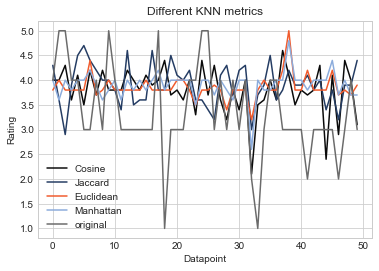

In [24]:
plt.plot(test_cosine, label = "Cosine", color= '#0a0a0a')
plt.plot(test_jaccard, label = "Jaccard", color ='#243c63')
plt.plot(test_euclidean, label = "Euclidean", color ='#f15b2d')
plt.plot(test_manhattan, label = "Manhattan", color ='#8cacdc')
plt.plot(original, label = "original", color ='#6b6b6b')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Different KNN metrics')
plt.show()

`Original VS Cosine`

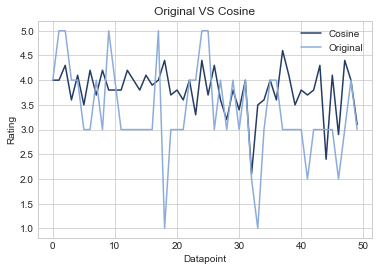

In [25]:
plt.plot(test_cosine, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

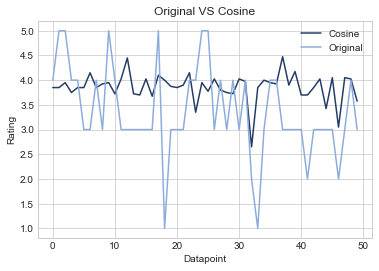

In [26]:
test_cosine1 = similarity('cosine', l, 20)
plt.plot(test_cosine1, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

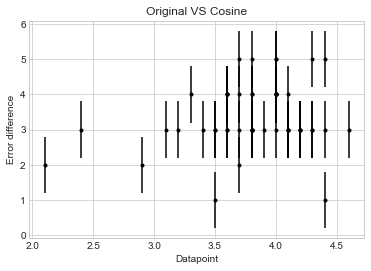

In [27]:
plt.errorbar(test_cosine, original, yerr=0.8, fmt='.k');
plt.xlabel("Datapoint")
plt.ylabel("Error difference")
plt.title('Original VS Cosine')
plt.show()

`Original VS Jaccard`

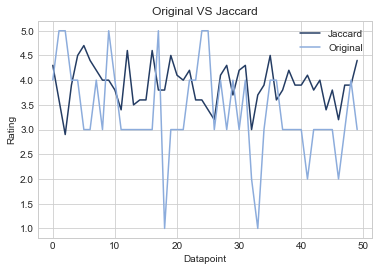

In [28]:
plt.plot(test_jaccard, label = "Jaccard",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Jaccard')
plt.legend()
plt.show()

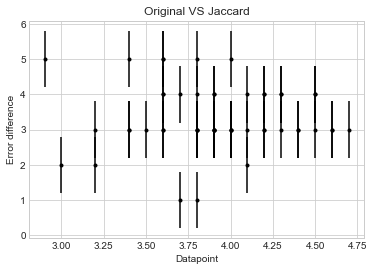

In [29]:
plt.errorbar(test_jaccard, original, yerr=0.8, fmt='.k');
plt.xlabel("Datapoint")
plt.ylabel("Error difference")
plt.title('Original VS Jaccard')
plt.show()

`Original VS Euclidean`

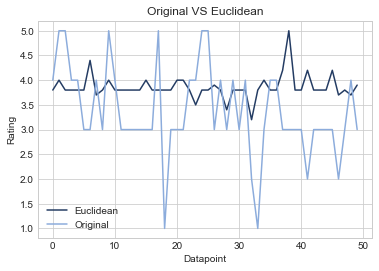

In [30]:
plt.plot(test_euclidean, label = "Euclidean",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Euclidean')
plt.legend()
plt.show()

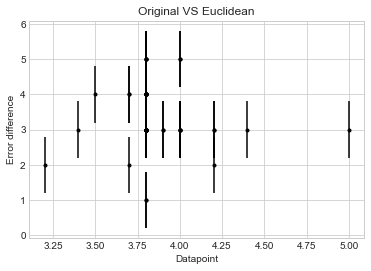

In [31]:
plt.errorbar(test_euclidean, original, yerr=0.8, fmt='.k');
plt.xlabel("Datapoint")
plt.ylabel("Error difference")
plt.title('Original VS Euclidean')
plt.show()

`Original VS Manhattan`

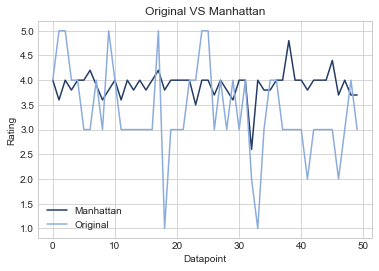

In [32]:
plt.plot(test_manhattan, label = "Manhattan",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Manhattan')
plt.show()

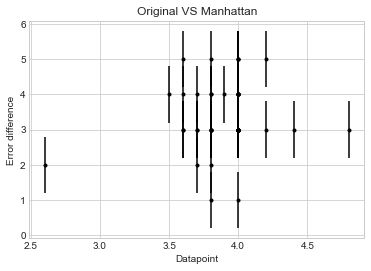

In [33]:
plt.errorbar(test_manhattan, original, yerr=0.8, fmt='.k');
plt.xlabel("Datapoint")
plt.ylabel("Error difference")
plt.title('Original VS Manhattan')
plt.show()

### `Evaluation`

We will use 
1. Root-mean-squared deviation
2. Mean Absolute Error 

In [34]:
e_cosine =[sklearn.metrics.mean_squared_error(original, test_cosine), mean_absolute_error(original,test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(original, test_jaccard), mean_absolute_error(original,test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(original, test_euclidean), mean_absolute_error(original,test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(original, test_manhattan), mean_absolute_error(original,test_manhattan)]

In [35]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "SVD" : [0.8744 , 0.6756]},
                index=['RMSE', 'MAE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,SVD
RMSE,1.0358,1.320,1.1532,1.1372,0.8744
MAE,0.7940,0.956,0.8920,0.8640,0.6756


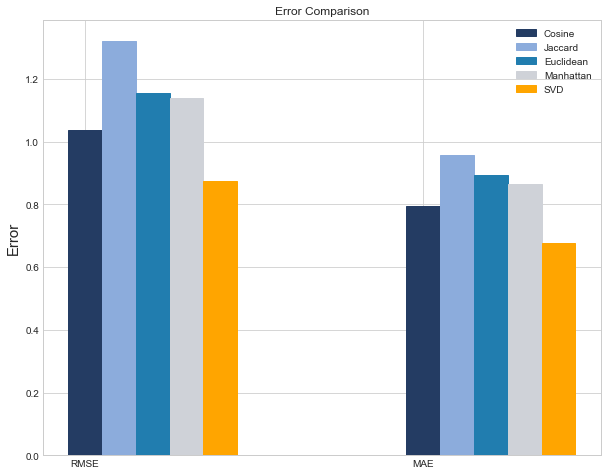

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, [0.8744 , 0.6756], color ='orange', width = barWidth,
		edgecolor ='orange', label ='SVD')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE' , 'MAE'])

plt.title('Error Comparison')
plt.legend()
plt.show()
